In [1]:
"""CVAE on MNIST
"""
import argparse
import os

import chainer
import pickle
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from PIL import Image, ImageDraw
import numpy as np
import cv2

import net 
import make_random_mnist
import make_random_selfdata
from chainer import serializers
%matplotlib inline

print(np.random.randint(0,2))

1


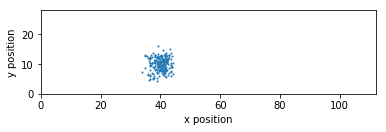

44.269032562207684
15.975476850971702


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

mu = [40, 10]
sigma = [[5, 0], [0, 5]]
values = np.random.multivariate_normal(mu, sigma, 200)
 
# 散布図
ax = plt.gca()
ax.scatter(values[:,0], values[:,1], s=1)
ax.set(ylim=(0,28), ylabel='y position', xlim=(0,28*4), xlabel='x position', aspect='equal')
plt.show()
print(max(values[:,0]))
print(max(values[:,1]))

In [3]:
# Visualize the results
def save_images(x, filename, h= 29, w=113, cols=3,rows=3):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(cols, rows, figsize=(9, 9), dpi=120, edgecolor='coral', linewidth=2)
    for ai, xi in zip(ax.ravel(), x):
        ai.imshow(xi.reshape(h, w))
    ai.set_title(filename)
    fig.savefig(filename)
    plt.show()
    
def save_onehotvec(x):
    plt.plot(x)
    plt.show()
    
def trainMyModel(model, x_train, x_test, options):
    if options.test:
        x_train, _ = chainer.datasets.split_dataset(x_train, 100)
        x_test, _ = chainer.datasets.split_dataset(x_test, 100)
    train_iter = chainer.iterators.SerialIterator(x_train, options.batchsize)
    test_iter = chainer.iterators.SerialIterator(x_test, options.batchsize,repeat=False, shuffle=False)
    
    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if options.initmodel:
        chainer.serializers.load_npz(options.initmodel, model)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(train_iter, optimizer,device=options.gpu, loss_func=model.get_loss_func())

    trainer = training.Trainer(updater, (options.epoch, 'epoch'), out=options.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=options.gpu,eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(100, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if options.resume:
        chainer.serializers.load_npz(options.resume, trainer)

    # Run the training
    print(options.epoch)
    trainer.run()
    model.to_cpu()
    serializers.save_npz("mymodel_final.npz", model)
    return model

def testMyModel(model, x_test):
    pass

In [4]:
def load_save_random_dataset_withlabel(fname, n):
    dataset = make_random_mnist.MakeRandomMNIST()
    if os.path.exists(fname):
        with open(fname, mode='rb') as f:
            ret = pickle.load(f)
            return ret
    v = dataset.get_random_dataset_with_label(n)
    with open(fname, mode='wb') as f:
        pickle.dump(v, f)
        return v

def dispImage(img_vec):
    #title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    fig = plt.figure()
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    #plt.title(title)
    plt.show()

def dispOneHotVec(img, vec, vec_size,vec_ratio):
    t_img = img.copy() # cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #print(np.where(vec==1))
    hotvec = vec.reshape(vec_size)
    #print(hotvec.shape)
    cx, cy = np.where(hotvec == 1)
    #print(cx, cy)
    conv_img_coord_x = (cy*vec_ratio)+14
    conv_img_coord_y = (cx*vec_ratio)+14
    t_img = cv2.circle(t_img, (conv_img_coord_x,conv_img_coord_y), 1, (255, 0, 0), thickness=-1, lineType=cv2.LINE_8, shift=0)
    t_img = cv2.rectangle(t_img, (conv_img_coord_x-14,conv_img_coord_y-14), 
                          (conv_img_coord_x+14,conv_img_coord_y+14), (255,0,0), thickness=0, lineType=cv2.LINE_8, shift=0)
    fig = plt.figure() # Figureオブジェクトを作成
    ax = fig.add_subplot(1,1,1) # figに属するAxesオブジェクトを作成
    plt.imshow(t_img)
    plt.show()
def dispCropPos(img, data, label_vec_size, vec_ratio, color=(248,169,0)):
    t_img = img.copy()
    for n in range(len(data)):
        im, la = data[n]
        #print(la.shape)
        hotvec = la.reshape(label_vec_size)
        cx, cy = np.where(hotvec == 1)
        conv_img_coord_x = (cy*vec_ratio)+14
        conv_img_coord_y = (cx*vec_ratio)+14
        t_img[conv_img_coord_y, conv_img_coord_x] = color
    return t_img

def separetePosition_and_angle_probabilityMap(data, data_len, border):
    angle_map_l = len(data[0]) - border 
    pos_map = np.zeros((data_len, border), dtype=np.float32)
    angle_map = np.zeros((data_len, angle_map_l), dtype=np.float32)
    for n in range(data_len):
        pos_map[n,:] = data[n][0:border]
        angle_map[n,:] = data[n][border:]
    return pos_map, angle_map

In [5]:
def chageBrightness(data, label_vec_size):
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for i in range(data_num):
        img, label = data[i]
        rand_gain = np.random.uniform(-0.3, 0.3, (28*28))
        im = img+rand_gain
        # 0 miman
        im = np.where(im > 1, 1, im)
        # 1 izyou
        im = np.where(im < 0, 0, im)
        images[i, :] = im
        labels[i, :] = label
    return chainer.datasets.TupleDataset(images, labels)

def addGomashio(data, label_vec_size):
    size = 1
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for n in range(data_num):
        x = int(np.random.uniform(0,27))
        y = int(np.random.uniform(0,27))
        c = int(np.random.uniform(0,256))
        img, label = data[n]
        img = (img * 256).reshape((28, 28))
        img = cv2.rectangle(img, (x, y),(x+size,y+size), c, -1)
        img = img.flatten()
        images[n, :] = img/256.
        labels[n, :] = label
    return chainer.datasets.TupleDataset(images, labels)

GPU: 0
# dim z: 1
# Minibatch-size: 300
# epoch: 1200

1200


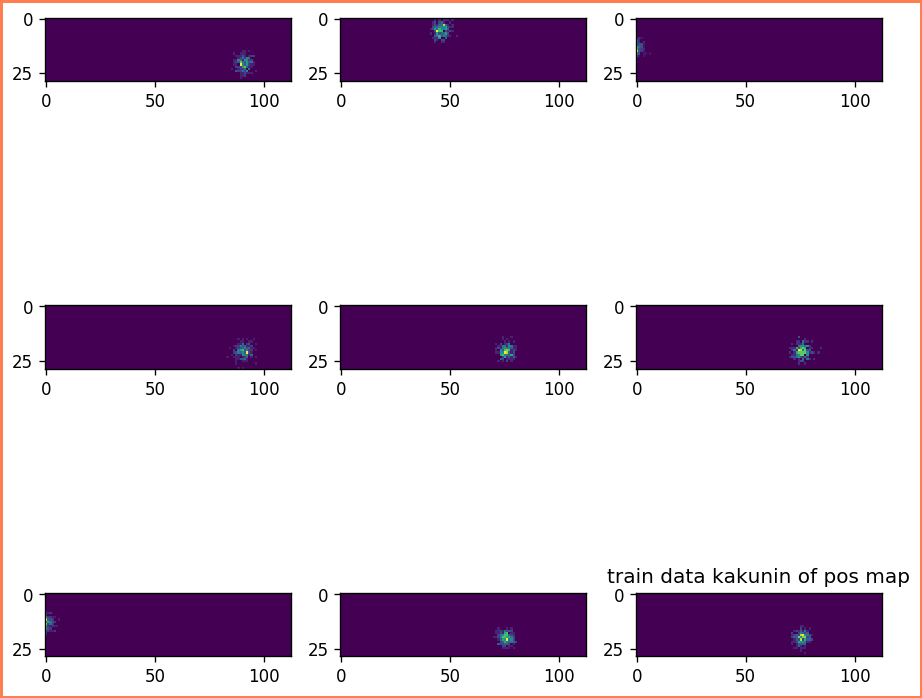

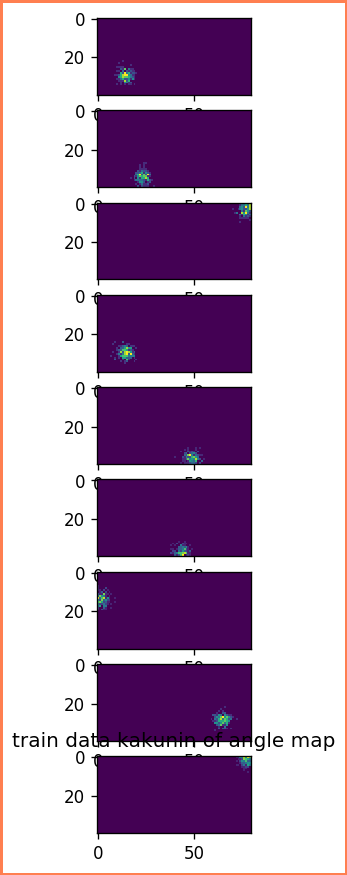

訓練データの画像


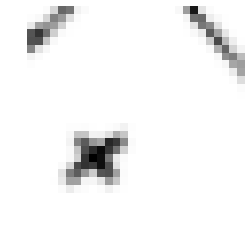

128 91 21 deg, posx, posy
回転する前の画像


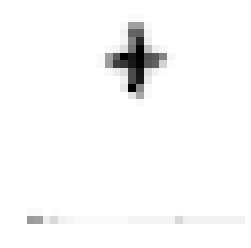

回転した画像


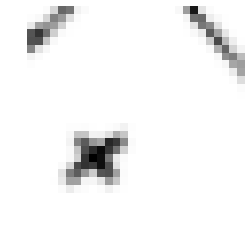

訓練データの画像


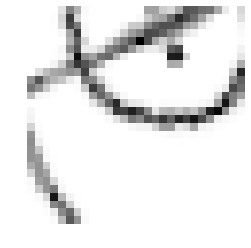

114 46 6 deg, posx, posy
回転する前の画像


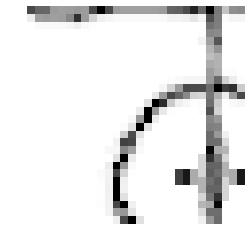

回転した画像


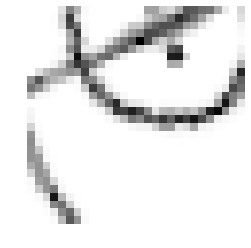

訓練データの画像


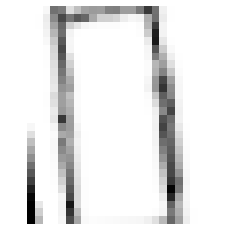

6 0 14 deg, posx, posy
回転する前の画像


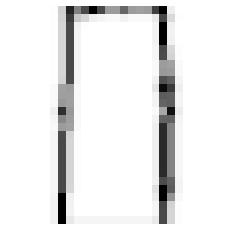

回転した画像


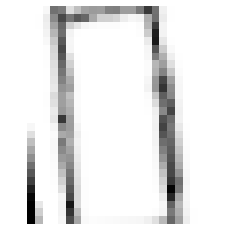

訓練データの画像


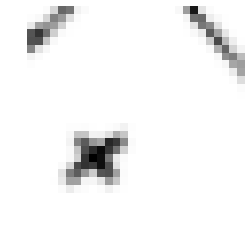

128 91 21 deg, posx, posy
回転する前の画像


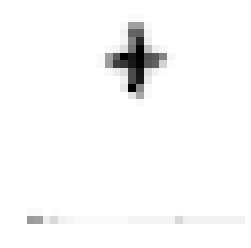

回転した画像


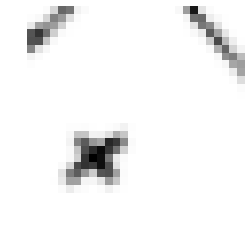

訓練データの画像


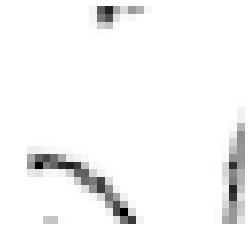

76 76 21 deg, posx, posy
回転する前の画像


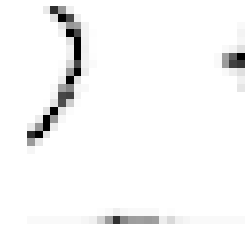

回転した画像


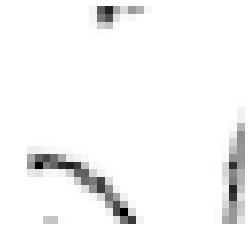

訓練データの画像


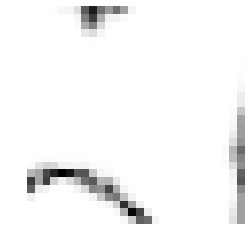

84 76 21 deg, posx, posy
回転する前の画像


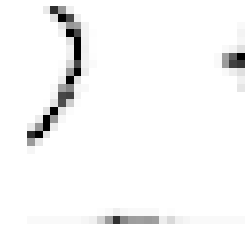

回転した画像


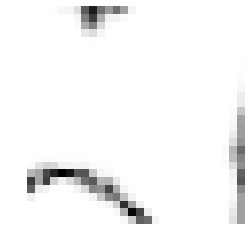

訓練データの画像


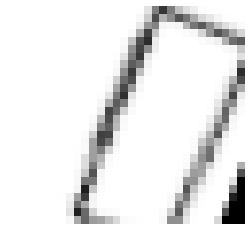

158 0 14 deg, posx, posy
回転する前の画像


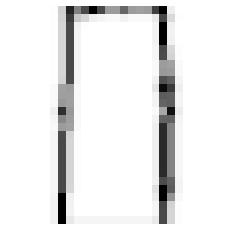

回転した画像


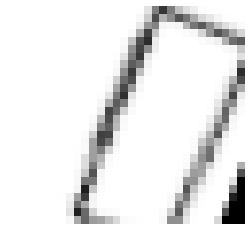

訓練データの画像


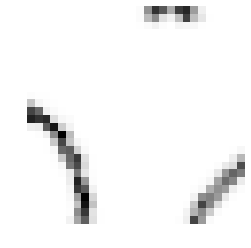

50 76 21 deg, posx, posy
回転する前の画像


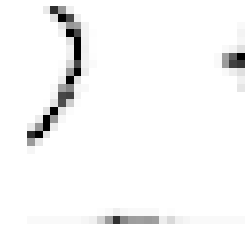

回転した画像


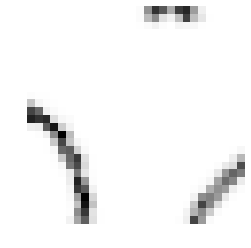

訓練データの画像


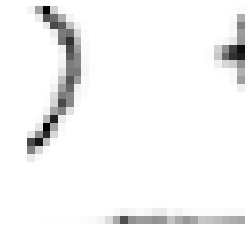

4 76 21 deg, posx, posy
回転する前の画像


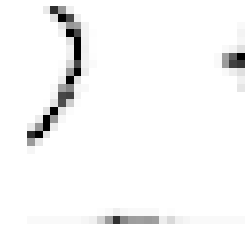

回転した画像


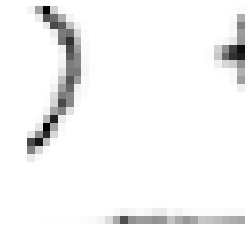

NLABEL 784
CONDITION 784
CONTEXT 6477
1200
epoch       main/loss   validation/main/loss  main/rec_loss  validation/main/rec_loss  elapsed_time
1           2344.75     220.934               2314.25        206.802                   0.654286      
2           225.912     198.947               215.792        190.843                   0.825692      
3           197.178     192.61                189.057        184.362                   0.982447      
4           189.108     178.092               180.819        170.008                   1.1397        
5           177.863     170.912               170.029        163.998                   1.29701       
6           172.545     166.532               166.195        161.238                   1.45339       
7           169.287     164.221               164.318        159.785                   1.60945       
8           166.409     161.306               162.235        157.788                   1.76783       
9           164.112     160.236          

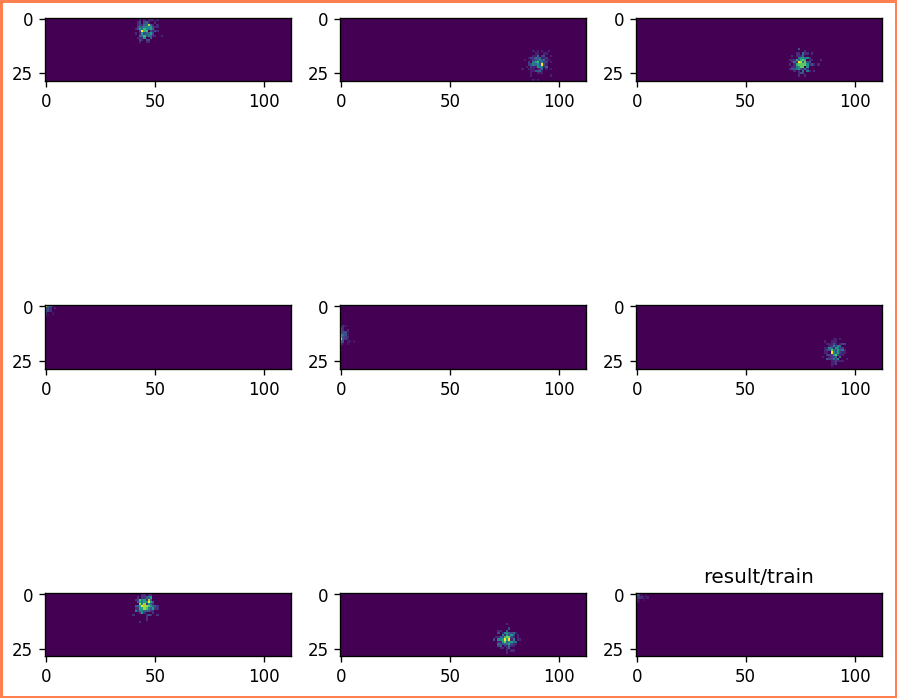

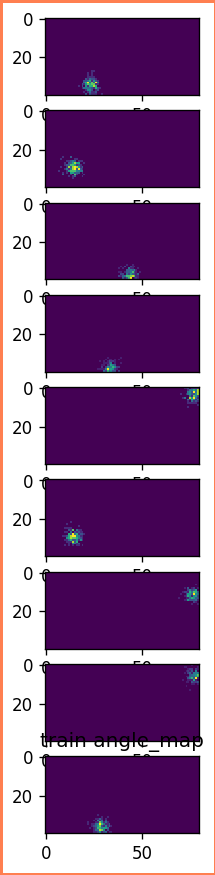

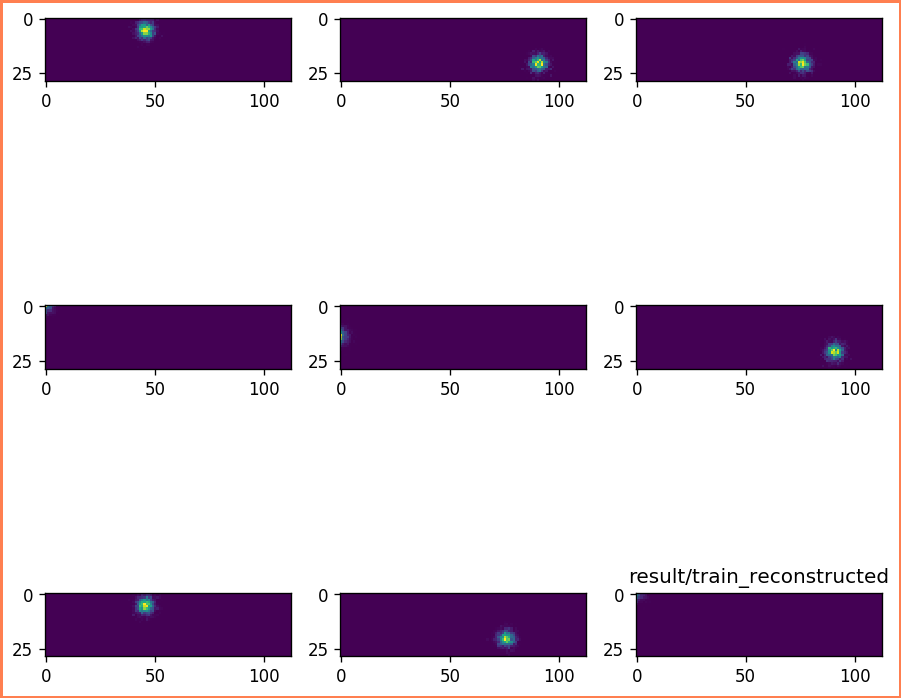

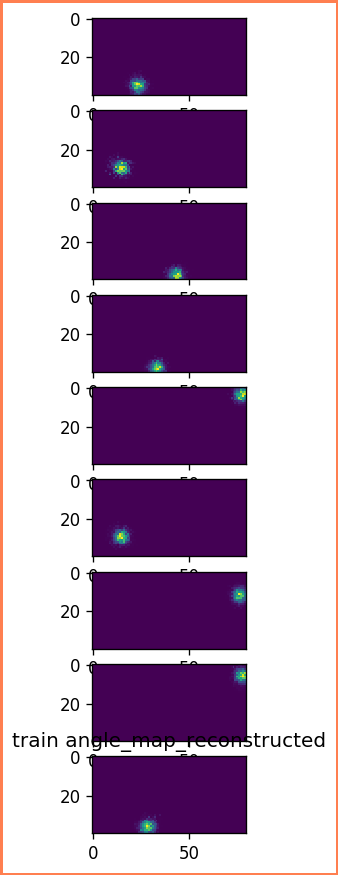

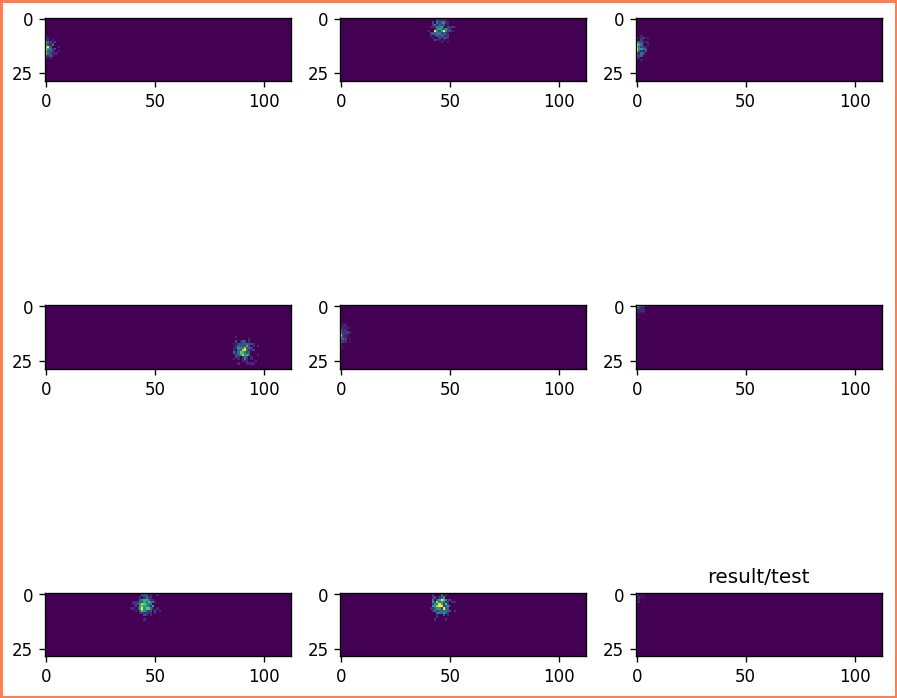

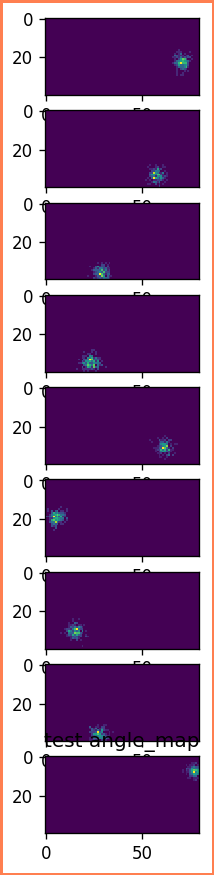

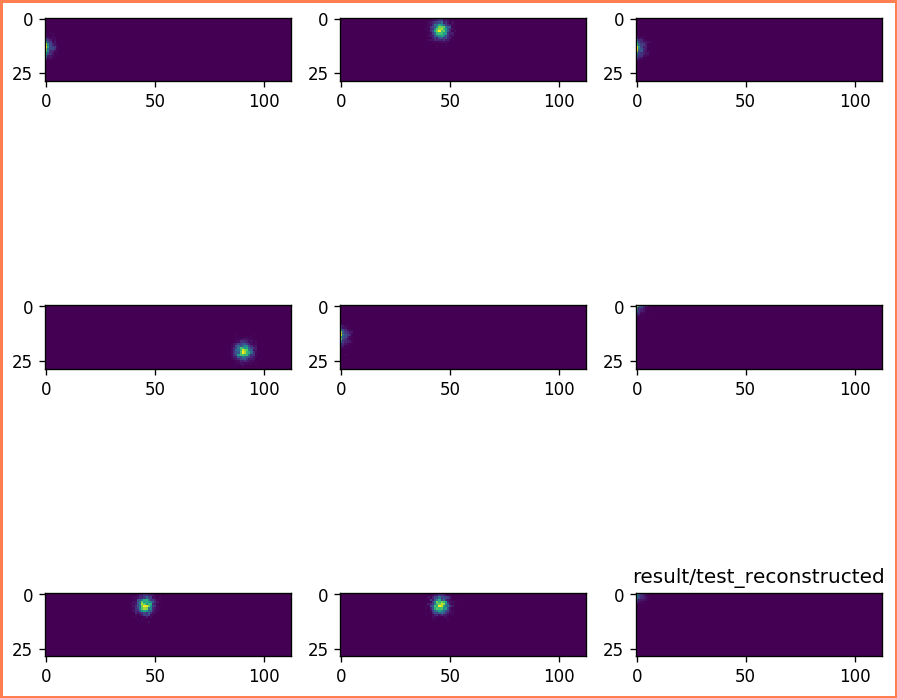

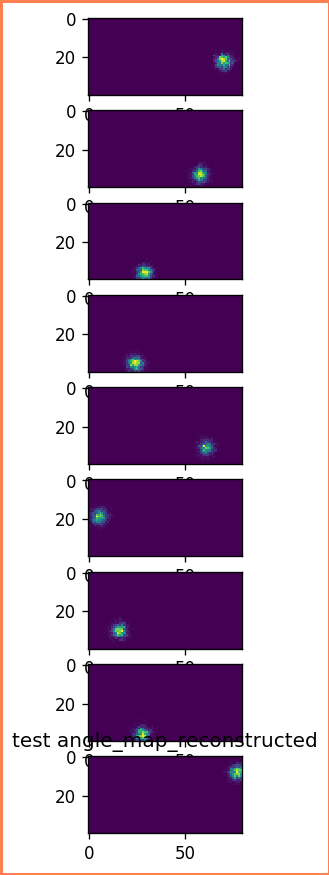

In [6]:
def main():
    global NLABELDIM, NZDIM, HIDDEN
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=1200, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=1, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=300,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args=['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    #img = '../images/chizu_naga.png'
    img = '../images/field_zyouge_sayuu_hanten.png'
    #img = '../images/field.png'
    dataset = make_random_selfdata.MakeRandomSelfdata(img)    
    global train,test, train_debug_data,test_debug_data, model
    #train = dataset.get_random_dataset_for_rcvae_with_2d_onehot(3000)
    #test = dataset.get_random_dataset_for_rcvae_with_2d_onehot(3000)
    #for t in range(10):
    #    dispImage(train[t][1])
    
    #train = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_sincos(3)
    #test = dataset.get_random_dataset_for_rcvae_with_2d_onehot_and_sincos(3) 
    
    train, train_debug_data = dataset.get_random_dataset_for_rcvae_with_2d_GentleOnehotSinCos(1200,0)
    test, test_debug_data = dataset.get_random_dataset_for_rcvae_with_2d_GentleOnehotSinCos(300,1)
    
    maps= list(map(lambda x:x[0], train))
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(maps, len(maps), dataset.onehot_w*dataset.onehot_h )
    print(len(angle_map))
    save_images(pos_map, 'train data kakunin of pos map')
    save_images(angle_map, 'train data kakunin of angle map', h=40, w=80,cols=9,rows=1)
    for n in range(9):
        print('訓練データの画像')
        dispImage(train[n][1])
        posx = train_debug_data[n][0].astype(np.int64)
        posy = train_debug_data[n][1].astype(np.int64)
        deg = train_debug_data[n][2].astype(np.int64)
        print(deg, posx-14, posy-14 , 'deg, posx, posy')
        print('回転する前の画像')
        p_im = dataset.getImage(posx, posy)
        dispImage(np.reshape(p_im,(28,28)))
        print('回転した画像')
        r_im, _ = dataset.getRotateImageAndRad(posx, posy, deg)
        dispImage(np.reshape(r_im,(28,28)))
        
    # Prepare CVAE model, defined in net.py
    NLABELDIM = len(train[0][1])
    CONTEXTDIM = len(train[0][0])
    HIDDEN =1300
    print('NLABEL', NLABELDIM)
    print('CONDITION', NLABELDIM)
    print('CONTEXT', CONTEXTDIM)
    NZDIM = args.dimz
    
    #print(len(train[0]))
    
    
    
    model = net.MyCVAE(CONTEXTDIM, args.dimz, HIDDEN, NLABELDIM)
    model = trainMyModel(model,train,test,args)
    
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in train_ind:
        x, t = train[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xin, len(xin), dataset.onehot_w* dataset.onehot_h)
    print(len(angle_map))
    save_images(pos_map, os.path.join(args.out, 'train'))
    save_images(angle_map, 'train angle_map', h=40, w=80,cols=9,rows=1)

    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xout, len(xout), dataset.onehot_w* dataset.onehot_h)
    save_images(pos_map, os.path.join(args.out, 'train_reconstructed'))
    save_images(angle_map, 'train angle_map_reconstructed', h=40, w=80,cols=9,rows=1)

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in test_ind:
        x, t = test[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xin, len(xin), dataset.onehot_w* dataset.onehot_h)
    save_images(pos_map, os.path.join(args.out, 'test'))
    save_images(angle_map, 'test angle_map', h=40, w=80,cols=9,rows=1)
    pos_map, angle_map = separetePosition_and_angle_probabilityMap(xout, len(xout), dataset.onehot_w* dataset.onehot_h)
    save_images(pos_map, os.path.join(args.out, 'test_reconstructed'))
    save_images(angle_map, 'test angle_map_reconstructed', h=40, w=80,cols=9,rows=1)
    
    # 訓練のログデータを残す部分
    log_data = str(args.epoch)+ ', '+ str(args.batchsize)+ ', '+str(args.dimz) +','+ str(dataset.rotation_angle) + ',' + str(NLABELDIM)+ ',' +str(CONTEXTDIM)+ ',' +str(HIDDEN)
    f = open('training_data.log', 'w')
    f.write(log_data)
    f.close()
if __name__ == '__main__':
    main()

# conditionで位置マップを生成するための共通の部分

In [7]:
'''
NZDIM = 1
NLABELDIM = 784 #len(train[0][1])
CONTEXTDIM = 6477 #len(train[0][0])
model = net.MyCVAE(CONTEXTDIM, NZDIM, HIDDEN, NLABELDIM)
serializers.load_npz("mymodel_final.npz", model)
# draw images from randomly sampled z
#z = chainer.Variable(np.random.normal(0, 1, (10, NZDIM)).astype(np.float32))
z = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))
'''

'\nNZDIM = 1\nNLABELDIM = 784 #len(train[0][1])\nCONTEXTDIM = 6477 #len(train[0][0])\nmodel = net.MyCVAE(CONTEXTDIM, NZDIM, HIDDEN, NLABELDIM)\nserializers.load_npz("mymodel_final.npz", model)\n# draw images from randomly sampled z\n#z = chainer.Variable(np.random.normal(0, 1, (10, NZDIM)).astype(np.float32))\nz = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))\n'

# Condition(Cropした犬の画像)から位置マップを出力する

-1.0


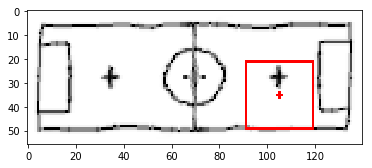

19.0


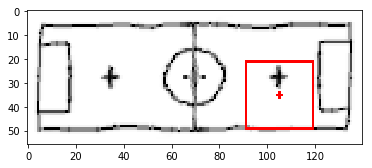

39.0


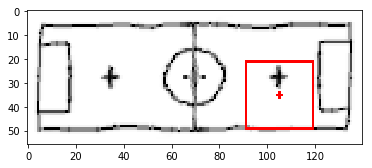

59.0


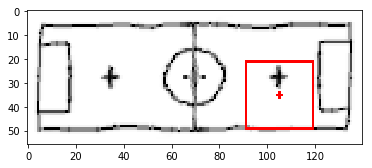

79.0


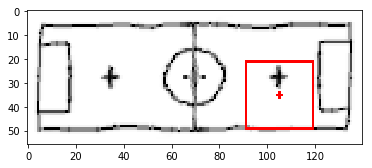

99.0


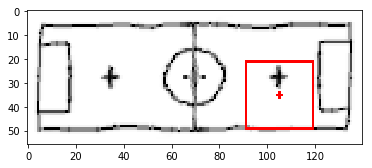

119.0


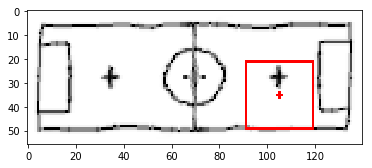

139.0


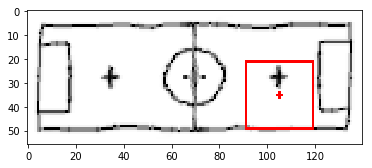

159.0


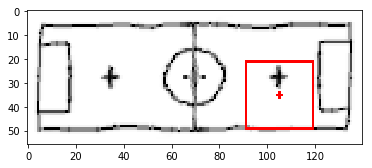

179.0


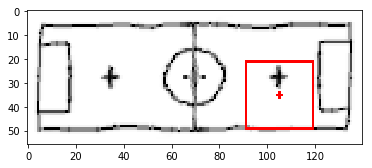

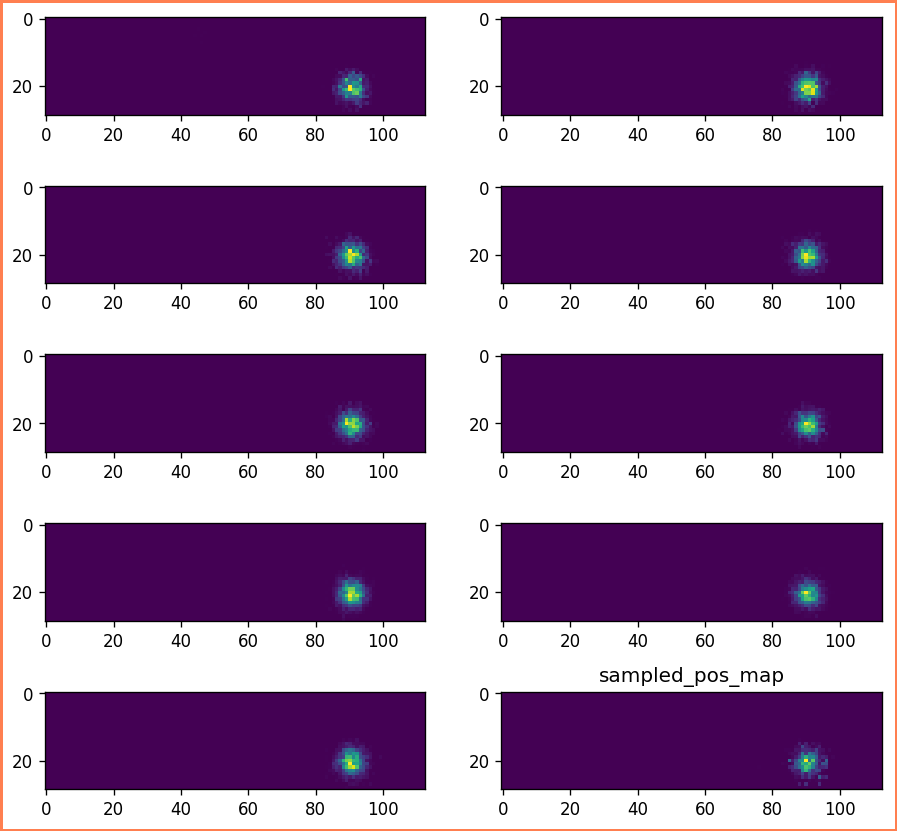

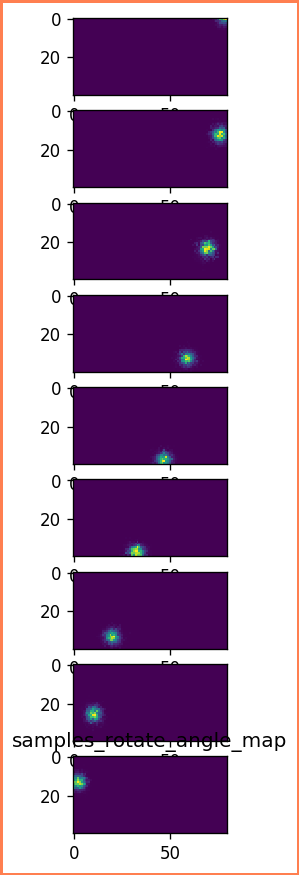

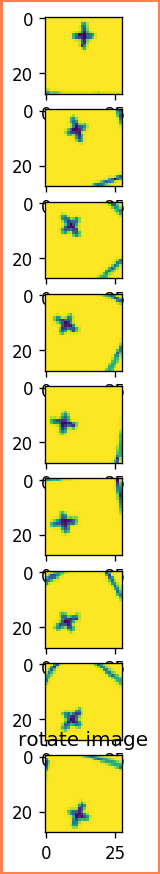

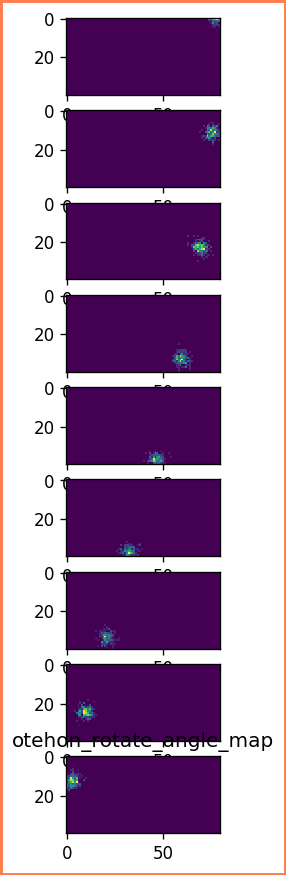

テストデータの画像
0 番目
93 91 21 deg, posx, posy


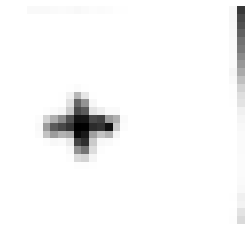

テストデータの画像
1 番目
105 0 14 deg, posx, posy


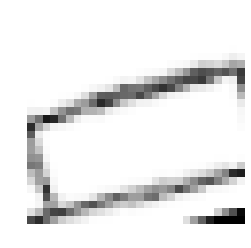

テストデータの画像
2 番目
61 46 6 deg, posx, posy


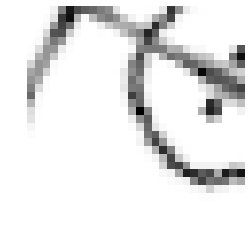

テストデータの画像
3 番目
37 0 14 deg, posx, posy


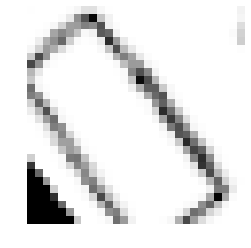

テストデータの画像
4 番目
55 0 14 deg, posx, posy


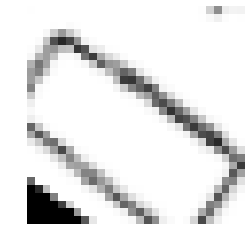

テストデータの画像
5 番目
149 46 6 deg, posx, posy


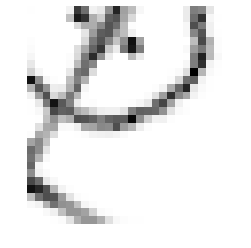

テストデータの画像
6 番目
61 76 21 deg, posx, posy


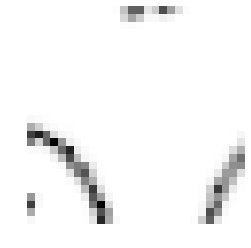

テストデータの画像
7 番目
69 0 0 deg, posx, posy


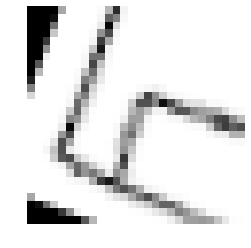

テストデータの画像
8 番目
149 0 0 deg, posx, posy


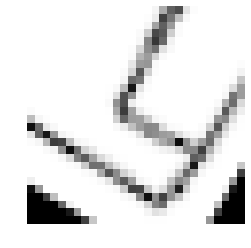

テストデータの画像
9 番目
81 0 0 deg, posx, posy


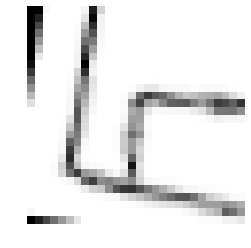

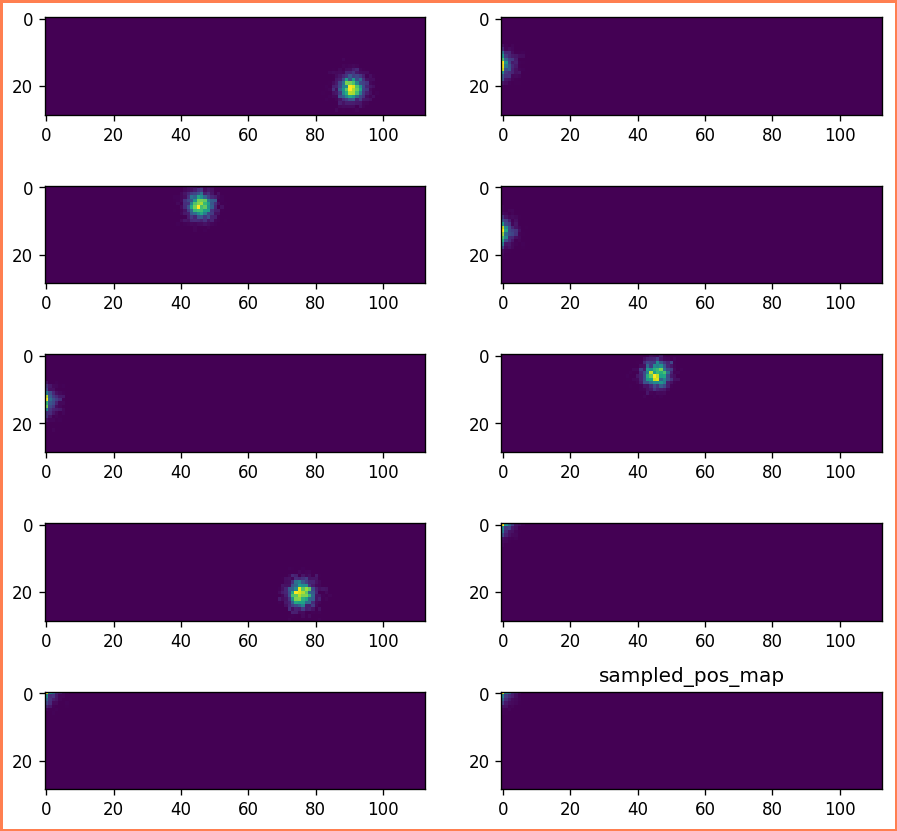

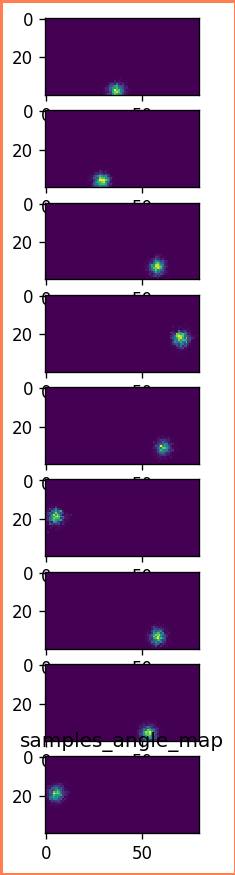

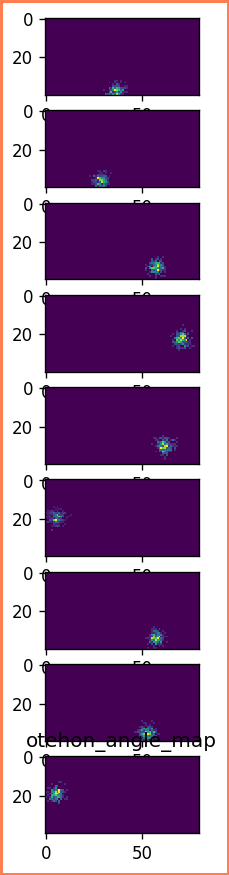

In [21]:

z = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))
img = '../images/field_zyouge_sayuu_hanten.png'
#img = '../images/field.png'
t_img = cv2.imread(img)
dataset = make_random_selfdata.MakeRandomSelfdata(img)
onehot_size = dataset.getOnehotSize()

labels = np.zeros((10, dataset.onehot_w*dataset.onehot_h + 40*80), dtype=np.float32)       # one hot vector
images = np.zeros((10, 28*28), dtype=np.float32)       # condition
angles = np.zeros((10, 40*80), dtype=np.float32)

n = np.linspace(0, 180, 10, dtype=int)
for i in range(10):
    cx = 105
    cy = 35
    t = n[i]*0.5
    r_deg = 2*(t) - 1
    print(r_deg)
    l = dataset.getLabel(cx, cy)
    im, _ = dataset.getRotateImageAndRad(cx, cy, r_deg)
    #im = dataset.getImage(14, 14)
    dispOneHotVec(t_img, l,dataset.getOnehotSize(),dataset.onehot_ratio)
    angle_map = dataset.make_angle_map(r_deg)
    pos_map = dataset.make_gentle_onehot_vec_2d(np.reshape(l, (dataset.onehot_h,dataset.onehot_w)))
    labels[i, :] = np.concatenate([pos_map, angle_map])
    images[i, :] = np.reshape(im, 28*28)
values = images
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x = model.decode(z, np.expand_dims(values, axis=1))
pos_map, angle_map = separetePosition_and_angle_probabilityMap(x.data, len(x.data), dataset.onehot_w* dataset.onehot_h)
save_images(pos_map, 'sampled_pos_map',cols=5, rows=2)
save_images(angle_map, 'samples_rotate_angle_map', h=40, w=80,cols=9,rows=1)
save_images(images, 'rotate image', h=28, w=28,cols=9,rows=1)
otehon_pos_map, otehon_angle_map = separetePosition_and_angle_probabilityMap(labels, len(x.data), dataset.onehot_w* dataset.onehot_h)
save_images(otehon_angle_map, 'otehon_rotate_angle_map', h=40, w=80,cols=9,rows=1)


for n in range(10):
    print('テストデータの画像')
    posx = test_debug_data[n][0].astype(np.int64)
    posy = test_debug_data[n][1].astype(np.int64)
    deg = test_debug_data[n][2].astype(np.int64)
    print(n, '番目')
    print(deg, posx-14, posy-14 , 'deg, posx, posy')
    r_im, rad = dataset.getRotateImageAndRad(posx, posy, deg)
    dispImage(r_im)
    images[n, :] = np.reshape(r_im, 28*28)
    angles[n, :] = dataset.make_angle_map(deg)
    #dispImage(np.reshape(r_im,(28,28)))
values = images
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x = model.decode(z, np.expand_dims(values, axis=1))
pos_map, angle_map = separetePosition_and_angle_probabilityMap(x.data, len(x.data), dataset.onehot_w* dataset.onehot_h)
save_images(pos_map, 'sampled_pos_map',cols=5, rows=2)
save_images(angle_map, 'samples_angle_map',h=40, w=80,cols=9,rows=1)
save_images(angles, 'otehon_angle_map',h=40, w=80,cols=9,rows=1)

variable([[0.]
          [0.]
          [0.]
          [0.]
          [0.]
          [0.]
          [0.]
          [0.]
          [0.]
          [0.]])
784
訓練データの画像
0 番目
128 91 21 deg, posx, posy


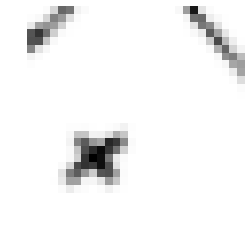

訓練データの画像
1 番目
114 46 6 deg, posx, posy


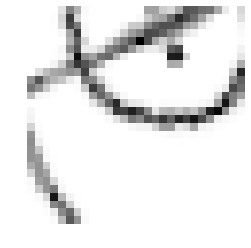

訓練データの画像
2 番目
6 0 14 deg, posx, posy


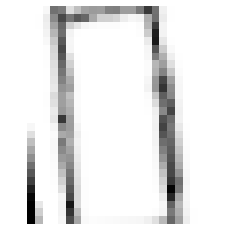

訓練データの画像
3 番目
128 91 21 deg, posx, posy


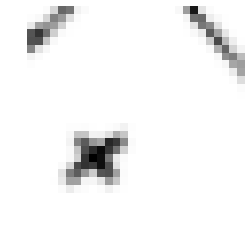

訓練データの画像
4 番目
76 76 21 deg, posx, posy


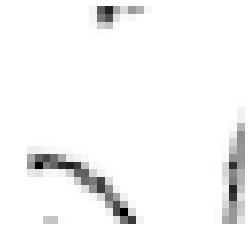

訓練データの画像
5 番目
84 76 21 deg, posx, posy


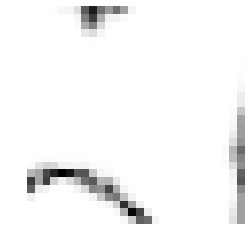

訓練データの画像
6 番目
158 0 14 deg, posx, posy


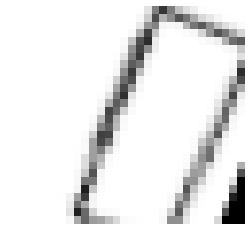

訓練データの画像
7 番目
50 76 21 deg, posx, posy


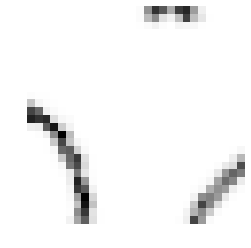

訓練データの画像
8 番目
4 76 21 deg, posx, posy


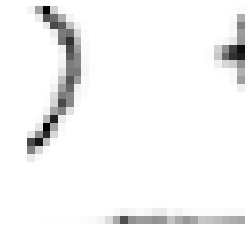

訓練データの画像
9 番目
40 0 14 deg, posx, posy


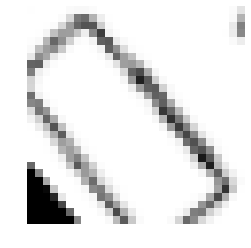

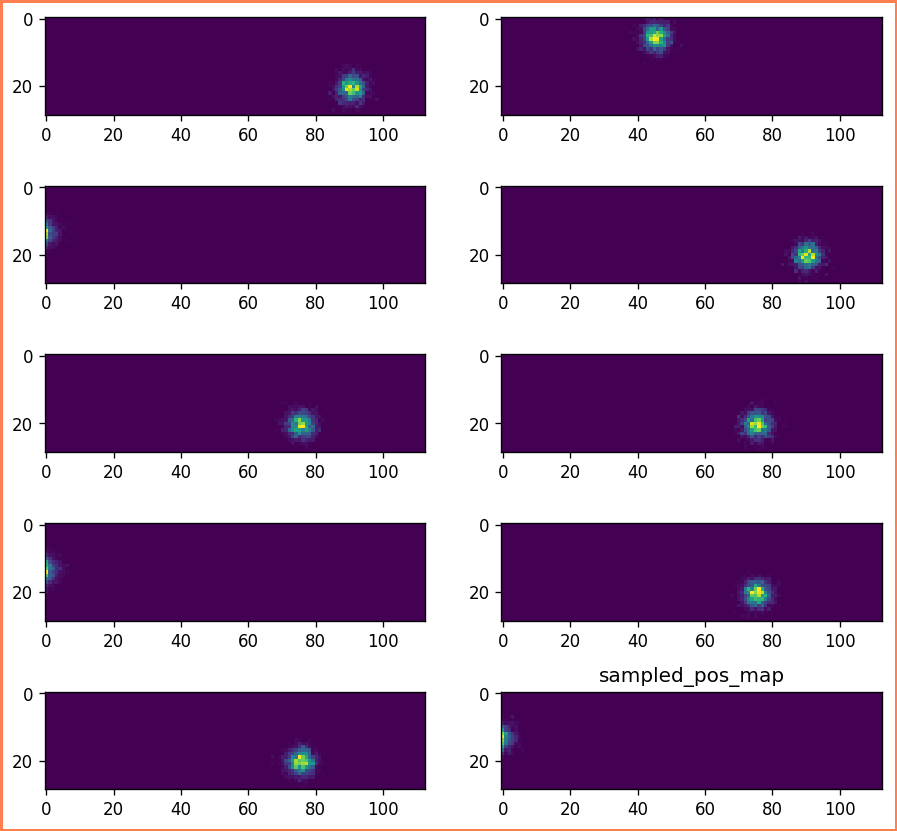

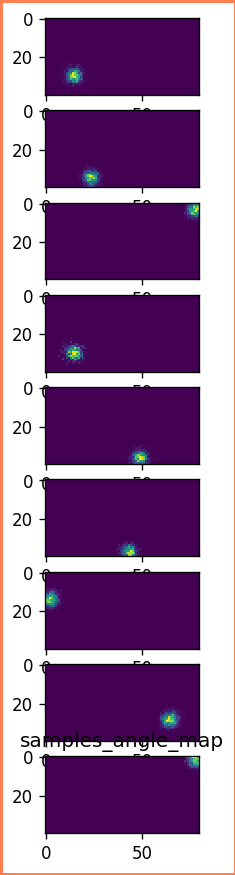

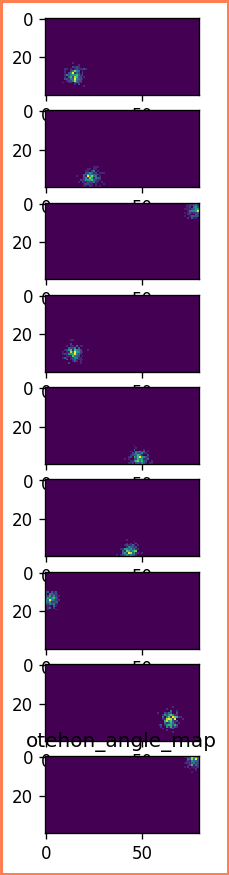

In [9]:
z = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))
print(z)
train_l_map = np.zeros((10,len(train[0][0])),dtype=np.float32)
train_l_img = np.zeros((10,len(train[0][1])),dtype=np.float32)
print(len(train[0][1]))
for i in range(10):
    train_l_map[i,:] = train[i][0]
    train_l_img[i,:] = train[i][1]
with chainer.using_config('train', False), chainer.no_backprop_mode():
    z1_mu, z1_ln_var = model.encode(train_l_map, train_l_img)
    
for i in range(10):
    pass

for n in range(10):
    print('訓練データの画像')
    posx = train_debug_data[n][0].astype(np.int64)
    posy = train_debug_data[n][1].astype(np.int64)
    deg = train_debug_data[n][2].astype(np.int64)
    print(n, '番目')
    print(deg, posx-14, posy-14 , 'deg, posx, posy')
    r_im, rad = dataset.getRotateImageAndRad(posx, posy, deg)
    dispImage(r_im)
    images[n, :] = np.reshape(r_im, 28*28)
    angles[n, :] = dataset.make_angle_map(deg)
    #dispImage(np.reshape(r_im,(28,28)))
values = images
with chainer.using_config('train', False), chainer.no_backprop_mode():
    x = model.decode(z1_mu, np.expand_dims(values, axis=1))
pos_map, angle_map = separetePosition_and_angle_probabilityMap(x.data, len(x.data), dataset.onehot_w* dataset.onehot_h)
save_images(pos_map, 'sampled_pos_map',cols=5, rows=2)
save_images(angle_map, 'samples_angle_map',h=40, w=80,cols=9,rows=1)
save_images(angles, 'otehon_angle_map',h=40, w=80,cols=9,rows=1)